## Import

In [1]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import nibabel as nib

## Data Load

In [2]:
zip_path = sorted(glob('/content/drive/Shareddrives/캡스톤 디자인1/dataset/multiclass_clahe_512/*'))

In [3]:
import zipfile
for path in zip_path:
  zip_file = zipfile.ZipFile(path)
  zip_file.extractall('/content/datasets/'+path.split('/')[-1].split('.')[0])
  zip_file.close()

In [4]:
PATH = '/content/datasets/'
from glob import glob
file_data = glob(PATH+'*')

In [5]:
image_path =list()
for path in file_data:
  infile_image_path = glob(path+'/*.png')
  image_path+=infile_image_path
image_path = sorted(image_path)

In [6]:
len(image_path)

55870

## Data Load

In [7]:
import pandas as pd
df= pd.read_csv('/content/drive/Shareddrives/캡스톤 디자인1/processed_data_entry.csv')

In [8]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,"Cardiomegaly,Emphysema",1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,"Cardiomegaly,Effusion",2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
76661,00030801_001.png,"Mass,Pneumonia",1,30801,38,M,PA,2048,2500,0.168,0.168
76662,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
76663,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
76664,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [9]:
labeling_df =pd.read_csv('/content/drive/Shareddrives/캡스톤 디자인1/multi_class_path+label_nofinding_drop.csv')

In [10]:
labeling_df

,Image Index,Finding Labels
0,/content/datasets/images_01/00000001_000.png,Cardiomegaly
1,/content/datasets/images_01/00000003_000.png,Hernia
2,/content/datasets/images_01/00000003_001.png,Hernia
3,/content/datasets/images_01/00000003_002.png,Hernia
4,/content/datasets/images_01/00000003_004.png,Hernia
...,...,...
30958,/content/datasets/images_12/00030780_000.png,Atelectasis
30959,/content/datasets/images_12/00030786_000.png,Effusion
30960,/content/datasets/images_12/00030786_006.png,Consolidation
30961,/content/datasets/images_12/00030789_000.png,Infiltration


In [11]:
value_series=labeling_df['Finding Labels'].value_counts()
value_dict = dict()
for i in range(len(value_series)):
    index = labeling_df['Finding Labels'].value_counts().index[i].split(',')
    if len(index) < 2: # dictionary data를 만들기 위해서 일단 단일의 질병만 가지고 있는 사람들을 dicstionary형태로 만듬.
        value_dict[index[0]] =  labeling_df['Finding Labels'].value_counts()[i]
label_list=sorted(list(value_dict.keys()))

In [12]:
label_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [13]:
class2idx = {cls:idx for idx, cls in enumerate(label_list)}
class2idx

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural_Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13}

In [14]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
encoder = LabelEncoder()
encoder.fit(label_list)

LabelEncoder()

In [15]:
dummy_label=encoder.transform((df[df['Image Index']==image_path[0].split('/')[-1]]['Finding Labels'].values[0]).split(','))

In [16]:
dummy_label

array([1])

In [17]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img/255
        img = img[:,:,np.newaxis]
        img = np.concatenate((img,img,img), axis = -1)
        label =class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed['image']
        return img, label

In [18]:
class val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img/255
        img = img[:,:,np.newaxis]
        img = np.concatenate((img,img,img), axis = -1)
        label =  class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed['image']
        return img, label

In [19]:
df[df['Image Index']== image_path[0].split('/')[-1]]['Finding Labels'].values[0]

'Cardiomegaly'

In [20]:
#!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 8.2 MB/s 
     |████████████████████████████████| 948 kB 55.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=870c266fbf59f018d1a83b9a7ff06f0c994c53ad79dd88467b19f7639cd8807d
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [21]:
import albumentations as A                                                                           
from albumentations.pytorch import ToTensorV2

In [22]:
data_transforms = {
    'train': A.Compose(
    [
     ToTensorV2()
     ]
    ),
    'val': A.Compose(
        [
     ToTensorV2()
                            ]
                           )
}
'''
A.RandomCrop(224, 224),
     A.OneOf([
              A.HorizontalFlip(p=1),
              A.RandomRotate90(p=1),
              A.VerticalFlip(p=1)            
    ], p=1), 
'''

'\nA.RandomCrop(224, 224),\n     A.OneOf([\n              A.HorizontalFlip(p=1),\n              A.RandomRotate90(p=1),\n              A.VerticalFlip(p=1)            \n    ], p=1), \n'

In [23]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(labeling_df,test_size = 0.2,random_state = 42,stratify = labeling_df['Finding Labels'])
train_path = list(train_df['Image Index'].values)
val_path = list(val_df['Image Index'].values)

In [24]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
num_classes = 15

# Batch size for training (change depending on how much memory you have)
batch_size = 2

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [25]:
train_data = Train_Dataset(train_path,transform = data_transforms['train'])
val_data = val_Dataset(val_path,transform =  data_transforms['val'])

In [26]:
image_datasets = {'train' : train_data , 'val' : val_data}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [27]:
model = torch.hub.load('pytorch/vision:v0.10.0','inception_v3',pretrained= True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [28]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score , roc_curve

In [29]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    
    train_acc_history = []
    train_loss_hist = [] 
    train_precision = [] 
    train_recall = [] 
    train_auc = [] 
    train_f1_score =[]
    val_loss_hist = []
    val_acc_history = [] 
    val_precision = [] 
    val_recall = [] 
    val_auc = [] 
    val_f1_score = []


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_precision =0
            running_recall = 0
            running_f1_score =0 
            running_auc = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device = device, dtype = torch.float32)
                labels = labels.to(device = device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs,aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs,labels)
                        
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                '''
                if phase =='train':
                  running_precision += precision_score(labels.to('cpu').numpy() , outputs.to('cpu').detach().numpy())
                  running_recall += recall_score(labels.to('cpu').numpy() , outputs.to('cpu').detach().numpy())
                  running_f1_score += f1_score(labels.to('cpu').numpy() , outputs.to('cpu').detach().numpy())
                  running_auc += roc_auc_score(labels.to('cpu').numpy() , outputs.to('cpu').detach().numpy())
                if phase =='val':
                  running_precision += precision_score(labels.to('cpu').numpy() , outputs.to('cpu').numpy())
                  running_recall += recall_score(labels.to('cpu').numpy() , outputs.to('cpu').numpy())
                  running_f1_score += f1_score(labels.to('cpu').numpy() , outputs.to('cpu').numpy())
                  running_auc += roc_auc_score(labels.to('cpu').numpy() , outputs.to('cpu').numpy())
                  '''

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            '''
            epoch_precision = running_precision/ len(dataloaders[phase].dataset)
            epoch_recall = running_recall/len(dataloaders[phase].dataset)
            epoch_f1_score = running_f1_score/len(dataloaders[phase].dataset)
            epoch_auc = running_auc/len(dataloaders[phase].dataset)
            '''
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_hist.append(epoch_loss)
              '''
              train_precision.append(epoch_precision)
              train_recall.append(epoch_recall)
              train_auc.append(epoch_auc)
              train_f1_score.append(epoch_f1_score)
              '''
            print('{} Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(phase, epoch_loss, epoch_acc,time.time()-start))
            #, P : {.4f} , R :{.4f} , AUC : {.4f}, f1 :{.4f} , , epoch_precision,epoch_recall, epoch_auc, epoch_f1_score 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)
                '''
                val_precision.append(epoch_precision)
                val_recall.append(epoch_recall)
                val_auc.append(epoch_auc)
                val_f1_score.append(epoch_f1_score)
                '''

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    train_dict = {'Loss' : train_loss_hist , 'Accuarcy' : train_acc_history}
    #, 'Precision' : train_precision, 'Recall' : train_recall, 'Auc' : train_auc , 'f1' : train_f1_score 
    val_dict = {'Loss' :val_loss_hist , 'Accuarcy' : val_acc_history}
    #, 'Precision' : val_precision , 'Recall' : val_recall, 'Auc' : val_auc , 'f1' : val_f1_score
    return model, train_dict ,val_dict

In [30]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [31]:
def initialize_model(model_ft, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299
    return model_ft, input_size

In [32]:
feature_extract = True
model_ft, input_size = initialize_model(model, 14, feature_extract, use_pretrained=True)

In [33]:
summary(model_ft.to('cuda'),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 255, 255]             864
       BatchNorm2d-2         [-1, 32, 255, 255]              64
       BasicConv2d-3         [-1, 32, 255, 255]               0
            Conv2d-4         [-1, 32, 253, 253]           9,216
       BatchNorm2d-5         [-1, 32, 253, 253]              64
       BasicConv2d-6         [-1, 32, 253, 253]               0
            Conv2d-7         [-1, 64, 253, 253]          18,432
       BatchNorm2d-8         [-1, 64, 253, 253]             128
       BasicConv2d-9         [-1, 64, 253, 253]               0
        MaxPool2d-10         [-1, 64, 126, 126]               0
           Conv2d-11         [-1, 80, 126, 126]           5,120
      BatchNorm2d-12         [-1, 80, 126, 126]             160
      BasicConv2d-13         [-1, 80, 126, 126]               0
           Conv2d-14        [-1, 192, 1

In [34]:
model_ft.fc

Linear(in_features=2048, out_features=14, bias=True)

In [35]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = [] # 파라미터 리스트 생성
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001) # 업데이트 할 파라미터만 넣어준다.

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [36]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [37]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft,  train_dict, val_dict= train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception= True)

Epoch 0/19
----------
train Loss: 3.4899 Acc: 0.2289, Time : 635.1970
val Loss: 2.3266 Acc: 0.3095, Time : 143.5639
Epoch 1/19
----------
train Loss: 3.5703 Acc: 0.2145, Time : 611.3449
val Loss: 2.5469 Acc: 0.1442, Time : 139.6647
Epoch 2/19
----------
train Loss: 3.5841 Acc: 0.2174, Time : 607.9123
val Loss: 2.2426 Acc: 0.2979, Time : 139.6584
Epoch 3/19
----------
train Loss: 3.5860 Acc: 0.2157, Time : 606.1211
val Loss: 2.3409 Acc: 0.3108, Time : 139.1212
Epoch 4/19
----------
train Loss: 3.5952 Acc: 0.2153, Time : 607.3469
val Loss: 2.2554 Acc: 0.2947, Time : 141.4390
Epoch 5/19
----------
train Loss: 3.5977 Acc: 0.2211, Time : 611.6617
val Loss: 2.3308 Acc: 0.3079, Time : 140.5211
Epoch 6/19
----------
train Loss: 3.5890 Acc: 0.2165, Time : 609.9243
val Loss: 2.4886 Acc: 0.2492, Time : 139.6343
Epoch 7/19
----------
train Loss: 3.5888 Acc: 0.2159, Time : 609.0092
val Loss: 2.5693 Acc: 0.3121, Time : 139.4867
Epoch 8/19
----------
train Loss: 3.5812 Acc: 0.2190, Time : 608.6418
va

In [71]:
 model.parameters

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 3, 3])


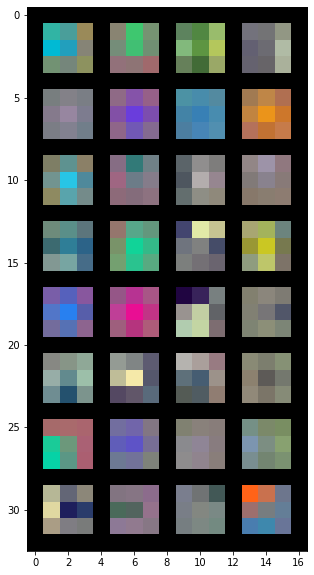

In [75]:
#레이어 시각화
i=0
for w in model.parameters():
    i+=1
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))

In [38]:
val_dict['Accuarcy'][1]

tensor(0.1442, device='cuda:0', dtype=torch.float64)

In [42]:
train_loss = []
val_loss = []

In [45]:
for i in range(len(train_dict['Loss'])):
  train_loss.append(train_dict['Loss'][i])
for i in range(len(val_dict['Loss'])):
  val_loss.append(val_dict['Loss'][i])

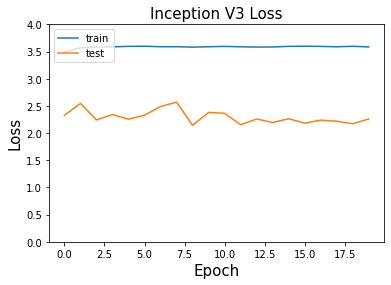

In [46]:
plt.plot(train_dict['Loss'])
plt.plot(val_dict['Loss'])
plt.title('Inception V3 Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,4)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [47]:
train_accuracy = []
val_accuracy = []

In [49]:
len(train_dict['Accuarcy'])

20

In [50]:
for i in range(len(train_dict['Accuarcy'])):
  train_accuracy.append(train_dict['Accuarcy'][i].to('cpu').numpy())
for i in range(len(val_dict['Accuarcy'])):
  val_accuracy.append(val_dict['Accuarcy'][i].to('cpu').numpy())

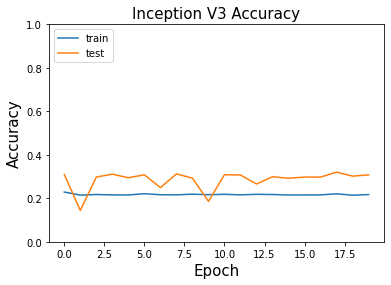

In [51]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Inception V3 Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
train_acc[0].to('cpu').numpy()

In [ ]:
train_accuracy

In [ ]:
torch.save(model_ft, '/content/drive/Shareddrives/캡스톤 디자인1/codes/Inceptionv3_multiclassclassfication_model_drop_nofinding_2')

In [ ]:
#model = torch.load('/content/drive/Shareddrives/캡스톤 디자인1/codes/Inceptionv3_multiclassclassfication_model_drop_nofinding')

In [ ]:
def initialize_model(model_ft, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299
    return model_ft, input_size

In [ ]:
feature_extract = True
model_ft, input_size = initialize_model(model, 14, feature_extract, use_pretrained=True)

In [ ]:
summary(model_ft.to('cuda'),(3,512,512))

In [52]:
class test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path).resize((299,299)))
        img = img/255
        img = img[:,:,np.newaxis]
        img = np.concatenate((img,img,img), axis = -1)
        label =  class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [53]:
data_transforms_test = A.Compose(
        [
     ToTensorV2()
                            ]
                           )


In [54]:
test_data = test_Dataset(val_path,transform = data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [55]:
import time

In [63]:
running_loss = 0.0
running_corrects = 0
start = time.time()
output_list = list()
label_list = list()
criterion = nn.CrossEntropyLoss()
for inputs, labels in test_loader:
    inputs = inputs.to(device = device, dtype = torch.float32)
    labels = labels.to(device = device)
    label_list+= list(labels.cpu().numpy())
    # zero the parameter gradients
    optimizer_ft.zero_grad()
    outputs = model_ft(inputs)
    output_softmax = nn.Softmax()(outputs)
    output_list+=list(torch.argmax(output_softmax,axis = 1).cpu().numpy())
    loss = criterion(outputs,labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(epoch_loss, epoch_acc, time.time()-start))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Test Loss: 2.5106 Acc: 0.2519, Time : 116.4476


In [60]:
torch.argmax(output_softmax)

tensor(8, device='cuda:0')

In [64]:
labels.cpu().numpy()

array([4])

In [65]:
torch.argmax(outputs,axis = 1).cpu().numpy()

array([8])

In [66]:
dummy_df = pd.DataFrame(output_list)

In [67]:
dummy_df.value_counts()

8     3356
13    1285
4     1214
11     216
0       55
2       37
10      16
9        7
5        3
6        3
1        1
dtype: int64

In [68]:
dummy_df_label = pd.DataFrame(label_list)

In [69]:
dummy_df_label.value_counts()

8     1910
0      843
4      791
10     541
13     439
9      428
2      262
11     225
1      219
5      178
6      145
3      126
12      64
7       22
dtype: int64